In [1]:
import sys 
sys.path.insert(0, '../src')
from src.visualization import visualize as vis
from src.data import data_functions as df
from src.models import model_architecture as march
from src.models import train_model as trm
from src.models import generate_model as gen

import os
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import wandb

# 0. Create Dataset of 2 Gaussians

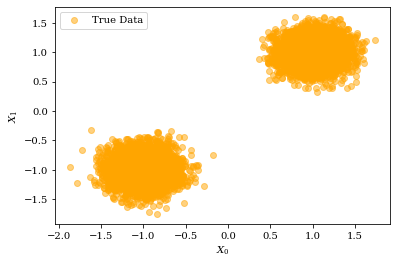

In [2]:
key = random.PRNGKey(0)
rng, subkey1, subkey2, subkey3, subkey4, subkey5, subkey6 = random.split(key, num=7)

size = 4000 # N
std = 0.2
mean_scale = 1

# Generate data for X_0 & X_1
X_0 = mean_scale + random.normal(subkey1, shape=(size, 2)) * std
X_1 = -mean_scale + random.normal(subkey2, shape=(size, 2)) * std

# Concantenate
X = jnp.concatenate([X_0, X_1], axis=0)

# Visuaize
plt.scatter(X[:, 0], X[:, 1], label='True Data', alpha=0.5, color='orange')
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.legend()
plt.show()

# 1. Construct Data Loader

In [3]:
train_dataset = df.JaxDataset(X=X)
train_loader = df.NumpyLoader(dataset=train_dataset, batch_size=512, shuffle=True)
batch = next(iter(train_loader))

# 2. Construct NN

In [4]:
model = march.ScoreNet(dim=2, latent_dim=256, std_data=0.5)

# Create random array of noise to instantiate model to print model summary
rnd_normal = random.normal(subkey3, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)
print(model.tabulate(jax.random.PRNGKey(9), batch, t))


                                ScoreNet Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs           ┃ outputs          ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ ScoreNet │ - float32[512,2] │ float32[512,2]   │                   │
│         │          │ - float32[512,1] │                  │                   │
├─────────┼──────────┼──────────────────┼──────────────────┼───────────────────┤
│ Dense_0 │ Dense    │ float32[512,2]   │ float32[512,256] │ bias:             │
│         │          │                  │                  │ float32[256]      │
│         │          │                  │                  │ kernel:           │
│         │          │                  │                  │ float32[2,256]    │
│         │          │                  │                  │                   │
│         │          │     

# 3. Training Loop

In [5]:
config = {
    'seed': 21,
    'batch_size': 128,
    'learning_rate': 5e-3,
    'epochs': 2,
    'dim': 2,
    'latent_dim': 256, #32
    'std_data': 0.5, #0.5
    'D': 2048,
    'N': 2
}

# Get the rng & model instantiated
init_rng = random.PRNGKey(config['seed'])
model = march.ScoreNet(dim=config['dim'],
                 latent_dim=config['latent_dim'],
                 std_data=config['std_data'])

# Sample the noise distribution
rnd_normal = random.normal(subkey4, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)  

# Initialize the models state
state = trm.init_train_state(model=model,
                               random_key=init_rng,
                               x_shape=batch.shape,
                               t_shape=t.shape,
                               learning_rate=config['learning_rate'])

# Call the training function
model, state = trm.train_model(train_loader, model, state, config, wandb_logging=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mdowicz. Use `wandb login --relogin` to force relogin


100%|██████████| 2/2 [00:19<00:00,  9.50s/it]


# 4. Sampling Loop

In [6]:
config = {'seed': 21,
          'dim': 2,
          'latent_dim': 256,
          'std_data': 0.5}

# Get the rng & model instantiated
init_rng = random.PRNGKey(config['seed'])
model = march.ScoreNet(dim=config['dim'],
                 latent_dim=config['latent_dim'],
                 std_data=config['std_data'])  

batch = next(iter(train_loader))

updated_model = gen.load_checkpoint(ckpt_dir='PFGMPP/saved_models/toy/checkpoint_2.flax',
                                ckpt_file='checkpoint',
                                model=model)

In [7]:
samples, orig = gen.sample_loop(updated_model,
                                  num_steps=50,
                                  max_t=80,
                                  min_t=0.1,
                                  sample_size=2000,
                                  S_churn=0,
                                  S_min=0.01,
                                  S_max=5,
                                  S_noise=1,
                                  D=2048,
                                  N=2,
                                  rho=7,
                                  std_data=0.5,
                                  key=random.PRNGKey(43))

50it [00:04, 12.42it/s]


# 5. Visualize Generated Data

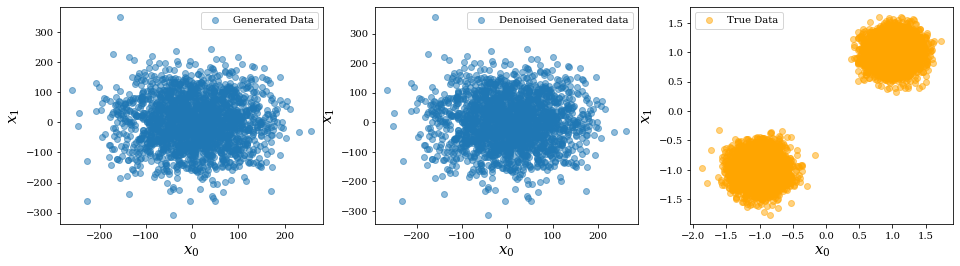

In [8]:
vis.sampling2D(prior_data=orig,
               true_data=X,
               generated_data=samples,
               std=0.2,
               mean_scale=1)